# NASA Challenger O-Ring Analysis

----

## Background

The NASA O-Ring dataset is data collected on Solid Rocket Boosters' O-Rings for rocket launches prior to the Challenger space shuttle launch.  The Challenger tragically exploded mid-launch on January 28, 1986 when a critical O-Ring failed to seal gases inside of the rocket booster. The leaked gases ignited causing a catastrophic explosion.

These brave astronauts perished in the incident:

Commander                 Francis R. Scobee 

Pilot                     Michael J. Smith

Mission Specialist One    Ellison S. Onizuka

Mission Specialist Two    Judith A. Resnik

Mission Specialist Three  Ronald E. McNair

Payload Specialist One    S. Christa McAuliffe

Payload Specialist Two    Gregory Bruce Jarvis

Prior to the launch NASA engineers and engineers from Morton Thiokol, the rocket manufacturer, worried that the low launchpad temperatures (<30\*F) might affect the o-rings' seal.  As part of their analysis they created a plot that only showed o-ring failures vs temperature. From this plot, which appeared to show random failures uncorrelated with temperature, the NASA team agreed to proceed to launch more than 20* colder than any previous launch.

Post-hoc analysis suggests that if they had plotted the successes and failures vs temperature together on the same plot, they would have immediatly noticed the frequency of failure increases as temperatures drop toward the temperature limit of the data set, 51*. This tragic event serves as a crucial example of the value of data visualization, and data analysis.

From the data available at the time, we produce the plot examined the day before launch together with the more appropriate plot. Additionally, we perform a bayesian analysis with the data where we model the probability of failure as a function of temperature.  The value of Bayesian Analysis is highlighted in this example because of the small data.  The probability of failure is an unknown quantity and its true value is best captured by a probability distribution over the range of possible values \[0,1\]. 

We use the Python language and Python package PYMC3 for the analysis.

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt
from scipy.stats.mstats import mquantiles

In [2]:
sys.version #Pymc3 has issues with Python 3.7+ - Activate a Python 3.6 kernel if your install is more current

'3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]'

In [3]:
oring_erosion_only = pd.read_csv('./o-ring-erosion-only.data',sep='\s+',header=None, names = ['oring_count','erosion','temperature','pressure','launch']) # import o-ring data for erosions, but no blowby
oring_erosion_blowby = pd.read_csv('./o-ring-erosion-or-blowby.data',sep='\s+',header=None, names = ['oring_count','erosion_or_blowby','temperature','pressure','launch']) # import o-oring data containing both erosions and blowby

In [73]:
oring_erosion_blowby.head()

,oring_count,erosion_or_blowby,temperature,pressure,launch,fault
0,6,0,66,50,1,0
1,6,1,70,50,2,1
2,6,0,69,50,3,0
3,6,0,68,50,4,0
4,6,0,67,50,5,0


In [74]:
oring_erosion_only.head()

,oring_count,erosion,temperature,pressure,launch
0,6,0,66,50,1
1,6,1,70,50,2
2,6,0,69,50,3
3,6,0,68,50,4
4,6,0,67,50,5


Important information is that each solid rocket booster was transported from the Morton Thiokol manufacturing facility in Utah, to the launch pad on Kennedy Space Center. It was transported in multiple pieces by train and then assembled on location. 

![Breakdown of the Solid Rocket Booster](Images/srb_breakdown.jpg)

The solid rocket booster was pieced together using sealing joins as diagramed below. Note that the right hand side of the image is the internal component of the tank, and the left hand side the external.

![Joint Seals](Images/sealing_mechanism.jpg)

In [5]:
# Lets convert the erosion_or_blowby count to a binary 'fault' variable
oring_erosion_blowby['fault'] = (oring_erosion_blowby['erosion_or_blowby'] > 0)*1
oring_erosion_blowby[['fault']];

# The Fateful Plot

The plot below is what was given to NASA engineers prior to Challenger launch. Clearly, no relationship could be inferred.

![The Fateful Plot](Images/failures_only.jpg)

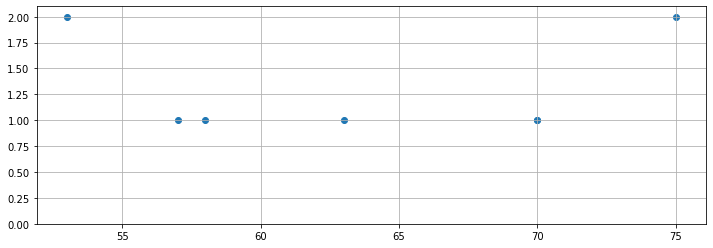

In [69]:
# Reproducing the plot in matplotlib
plt.figure(figsize=(12,4))
oring_eob_only = oring_erosion_blowby.loc[oring_erosion_blowby['fault']>0]
plt.scatter(oring_eob_only[["temperature"]], oring_eob_only[['erosion_or_blowby']])
plt.ylim((0,2.1))
plt.grid()

(0.0, 1.1)

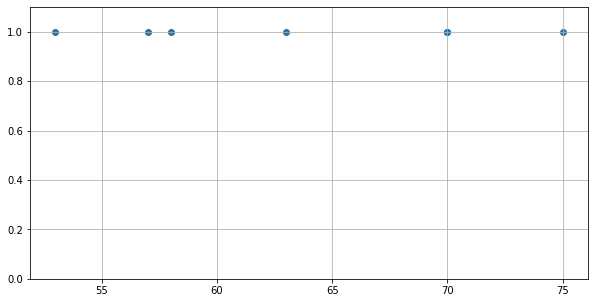

In [6]:
#
oring_fault_only = oring_erosion_blowby.loc[oring_erosion_blowby['fault']>0]
plt.figure(figsize=(10,5))
plt.scatter(oring_fault_only[['temperature']], oring_fault_only[['fault']])
plt.grid()
plt.ylim((0,1.1))

  The following two plots show the number of o-ring failures vs temp for all launches, and for all fails vs temperature respectively.

(-0.009, 1.1)

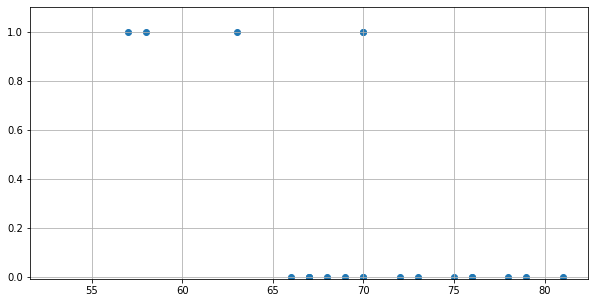

In [56]:
plt.figure(figsize=(10,5))
plt.scatter(oring_erosion_blowby[['temperature']],oring_erosion_blowby[['erosion_or_blowby']])
plt.grid()
plt.ylim((-0.009,1.1))

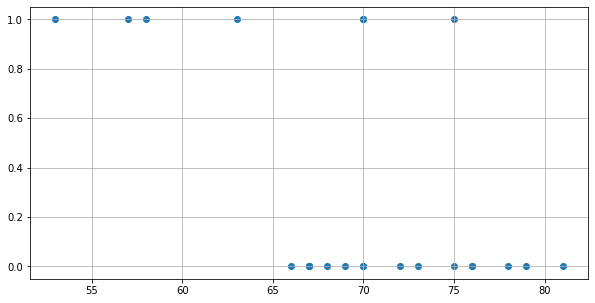

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(oring_erosion_blowby[['temperature']],oring_erosion_blowby[['fault']])
plt.grid()

In [9]:
with pm.Model() as logistic_regression:
    #data
    temp = pm.Data("temp",oring_erosion_blowby["temperature"]) # include our temperature data with the model. This is necessary so we can change it later on and predict for values not in our data
    press = pm.Data("press", oring_erosion_blowby["pressure"]) 
    fault = pm.Data("fault",oring_erosion_blowby["fault"])
    
    #params
    α = pm.Normal('α', 10, sigma=5)
    β_1 = pm.Normal('β_1', 0, sigma=.5)
    #β_2 = pm.Normal('β_2', 0, sd=.01)

    
    μ = pm.invlogit(α + β_1*temp) #  β_2*press)
    
    pm.Bernoulli("logit", p=μ, observed=fault)
    trace = pm.sample(draws=10000,tune=3000,chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_1, α]
Sampling 4 chains, 0 divergences: 100%|█| 52000/52000 [00:25<00:00, 2057.33draws/s]
The acceptance probability does not match the target. It is 0.881438699018338, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


C:\Users\Bleep\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Bleep\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Bleep\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Bleep\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CEDD1B3B08>,
      dtype=object)

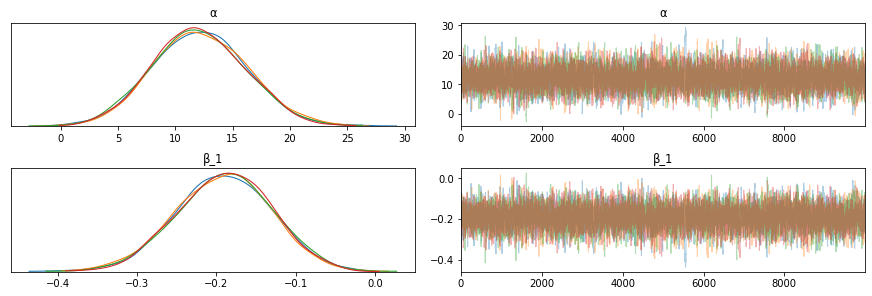

In [10]:
pm.traceplot(trace)

Lets look at a statistical summary of our posterior distributions.

In [11]:
pm.summary(trace,credible_interval=0.90)

,mean,sd,hpd_5%,hpd_95%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,12.137,4.072,5.712,19.036,0.056,0.041,5239.0,4854.0,5278.0,5700.0,1.0
β_1,-0.191,0.060,-0.288,-0.092,0.001,0.001,5224.0,4860.0,5264.0,5671.0,1.0


Now lets generate our posterior predictions!  Simply, we will randomly draw parameters from the posterior distributions solved above, then we use those parameters to generate samples from the predictive distribution.

In [13]:
with logistic_regression:
    pm.set_data({"temp" : np.linspace(20,100,100)})
    ppc = pm.sample_posterior_predictive(trace=trace, samples=1000)
    

C:\Users\Bleep\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|█████████████████████████████████████| 1000/1000 [00:07<00:00, 126.52it/s]


In [47]:
# Lets define a logistic function that will take our argu
def logistic(t, alpha, beta):
    return 1/(1+np.exp(-(alpha + beta*t)))

logistics = np.asarray([logistic(np.linspace(20,100,100),trace['α'][i], trace['β_1'][i]) for i in range(10000)])


In [48]:
np.std([row[50] for row in logistics])

0.1430672375240789

Text(0.5, 1.0, 'Probablity of O-Ring Failure')

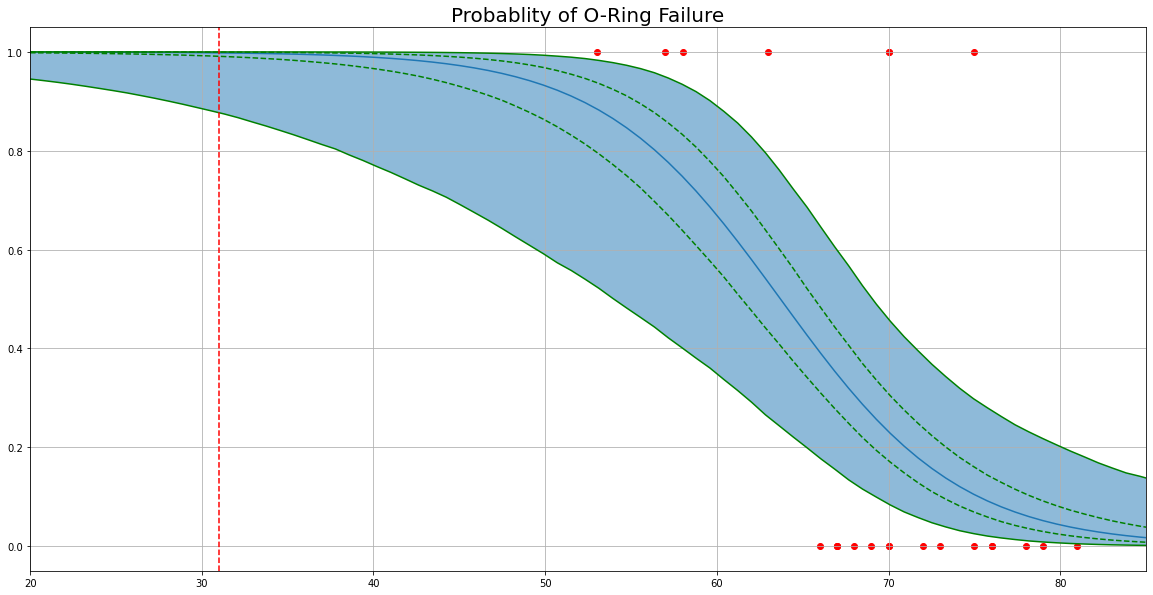

In [51]:
plt.figure(figsize=(20,10))
#plt.scatter(np.linspace(20,100,100),ppc['logit'][23])
plt.plot(np.linspace(20,100,100),1/(1+np.exp(-(trace['α'].mean() + trace['β_1'].mean()*np.linspace(20,100,100)))))
plt.scatter(oring_erosion_blowby[['temperature']],oring_erosion_blowby[['fault']], color='r')
# for i in range(1000):
#     plt.plot(np.linspace(20,100,100),logistics[i])
plt.plot(np.linspace(20,100,100),mquantiles(logistics,[0.025,0.975], axis=0)[0],color='g')
plt.plot(np.linspace(20,100,100),mquantiles(logistics,[0.025,0.975], axis=0)[1], color = 'g')
plt.plot(np.linspace(20,100,100),mquantiles(logistics,[0.25,0.75], axis=0)[0],color='g', linestyle='--')
plt.plot(np.linspace(20,100,100),mquantiles(logistics,[0.25,0.75], axis=0)[1], color = 'g', linestyle='--')
plt.fill_between(np.linspace(20,100,100),mquantiles(logistics,[0.025,0.975], axis=0)[0],mquantiles(logistics,[0.025,0.975], axis=0)[1], alpha=0.5)
plt.grid()
plt.xlim((20,85))
plt.axvline([31], color='r', linestyle='--')
plt.title("Probablity of O-Ring Failure",size=20)

Now, Lets plot the variance of our data as a function of temperatura. Notice that the variance is maximum around 55\*

(0.0, 105.0)

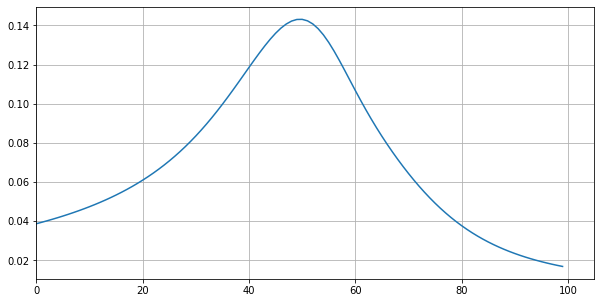

In [54]:
plt.figure(figsize=(10,5))
plt.plot([logistics[:,i].std() for i in range(100)])
plt.grid()
plt.xlim(0,105)

(array([745.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 255.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

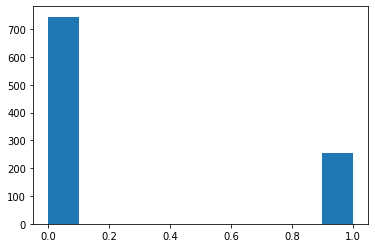

In [64]:
plt.hist(ppc['logit'][:,50])